In [68]:
import jax
import jax.numpy as jnp
from jax import random

In [36]:
import flax.linen as nn

class mlp(nn.Module):

    def setup(self):
        
        # Define Layers from input_sizes
        self.layers = [nn.Dense(3), nn.Dense(2)]

        self.nonlinearity = nn.tanh


    def __call__(self, x):
        
        # Apply transformation to u values
        for layer in self.layers[:-1]:
            x = self.nonlinearity(layer(x))
        out = nn.tanh(self.layers[-1](x))
        
        return out

In [69]:
class Interpolator1D(nn.Module):
    times: jnp.ndarray
    values: jnp.ndarray
    method: str

    def setup(self):
        pass 

    def __call__(self, t_evaluation, deg=None):
        if self.method == "linear":
            return self._linear_interpolate(t_evaluation)
        elif self.method == "cubic-poly":
            if deg is None:
                raise ValueError("Degree (deg) must be specified for cubic-polynomial interpolation.")
            return self._polynomial_interpolate(t_evaluation, deg)
        else:
            raise ValueError(f"Interpolation method '{self.method}' is not supported.")
    
    def _linear_interpolate(self, t_evaluation):
        idx = jnp.searchsorted(self.times, t_evaluation) - 1
        idx = jnp.clip(idx, 0, len(self.times) - 2)
        x0 = self.times[idx]
        x1 = self.times[idx + 1]
        y0 = self.values[idx]
        y1 = self.values[idx + 1]
        return y0 + (y1 - y0) * (t_evaluation - x0) / (x1 - x0)

In [38]:



def test_differentiability():

    rng = random.PRNGKey(42)

    # Example data
    times = jnp.linspace(0.0, 1000.0)
    values = random.uniform(rng, shape=(1000,))
    interp = Interpolator1D(times=times, values=values, method = 'linear')
    
    model = mlp()

    # plug an array of size 10 into interpolator
    times_eval = jnp.ones(10) * 0.66

    # Define a function to compute gradients
    def loss_fn(params):
        u_vals = interp(times_eval)
        loss =model.apply(params, u_vals)
        return jnp.sum(loss)

    # Compute the gradient with respect to learnable_param
    params = model.init(rng, jnp.zeros(10))
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(params)
    
    print("Gradients with respect to learnable_param:", grads)

# Run the test
test_differentiability()

Gradients with respect to learnable_param: {'params': {'layers_0': {'bias': Array([ 0.298245  , -0.60684896,  0.580353  ], dtype=float32), 'kernel': Array([[ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ],
       [ 0.17799823, -0.36217886,  0.3463656 ]], dtype=float32)}, 'layers_1': {'bias': Array([0.90200424, 0.79581684], dtype=float32), 'kernel': Array([[0.11305444, 0.09974524],
       [0.63889766, 0.56368417],
       [0.21263605, 0.18760373]], dtype=float32)}}}


In [107]:
class Integrator(nn.Module):
    strategy: str
    method: str
    interp: nn.Module 

    def setup(self):
        pass
    
    def __call__(self, fun, t_evaluation, y0):
        if self.strategy == 'fixed-grid':
            return self.fixed_grid(fun, t_evaluation, y0)
        elif self.strategy == 'adaptive':
            return self.adaptive(fun, t_evaluation, y0)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
    
    def fixed_grid(self, fun, t_evaluation, y0):
        """
        Perform numerical integration using fixed grid.
        """
        delta_ts = jnp.diff(t_evaluation)
        y = jnp.zeros_like(t_evaluation)
        y = y.at[0].set(y0)
        
        for en, (dt, t) in enumerate(zip(delta_ts, t_evaluation[:-1])):  # Exclude the last time step for iteration
            dy = self.step(fun, dt, t)
            y = y.at[en + 1].set(y[en] + dy)
        
        return (t_evaluation, y)

    def step(self, fun, dt, t):

        if self.method == 'euler':
            u = self.interp(t)
            dy = fun(u) * dt * 100
            return dy

In [108]:
import matplotlib.pyplot as plt

def u_function(t): 
        return jnp.sin(t)  

def output(t, y0):
    return 0.5 * jnp.cos(t) + 0.5

# Generate discrete time points, corresponding u values and output values
t_values = jnp.linspace(0, 5, 1000)
u_values = u_function(t_values)
out_values = output(t_values, 1.0)

# We basically want to learn the hidden derivative! i.e. how "output" values evolve w.r.t. to t and, actually, since we know this is the relevant variable, 
# w.r.t. another time series / function /measure "u". In our case we are interested in the quantity below

def derivative(u):
    return -0.5 * u

class approx_derivative(nn.Module):
     
     def setup(self):
          self.layers = [nn.Dense(3, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init()), 
                         nn.Dense(1, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())]

     def __call__(self, u):
        u = jnp.expand_dims(u, axis=0)
        out = u
        for layer in self.layers:
               out = nn.relu(layer(out))
        out = out.squeeze(axis = 0)
        return out


# Since our integrator might need to call the target parametrized function "derivative" multiple times points t, we first create an interpolator of u w.r.t. t
interp = Interpolator1D(t_values, u_values, method='linear')

# We then create our integrator, providing the interpolator
integ = Integrator(strategy='fixed-grid', method='euler', interp=interp)

# Initial condition
y0 = jnp.array(1.0)

# Time range for integration
t_evaluation = jnp.linspace(0, 5, 250)

In [109]:
class NeuralODE(nn.Module):

    f_prime_model: nn.Module
    integ_strat: str
    integ_meth: str 
    interp: nn.module

    def setup(self):

        self.integrator = Integrator(strategy=self.integ_strat, method=self.integ_meth, interp=self.interp)

    def __call__(self, times, iv):
    
        t_evaluation, out = self.integrator(self.f_prime_model, t_evaluation=times, y0=iv)

        return t_evaluation, out

{'f_prime_model': {'layers_0': {'bias': Array([ 1.1579626e-01, -5.1952797e+01,  2.1269942e+02], dtype=float32), 'kernel': Array([[-6.7773506e-02,  3.0407051e+01, -1.2448919e+02]], dtype=float32)}, 'layers_1': {'bias': Array([419.82294], dtype=float32), 'kernel': Array([[256.6018 ],
       [ 97.10022],
       [ 60.85085]], dtype=float32)}}}


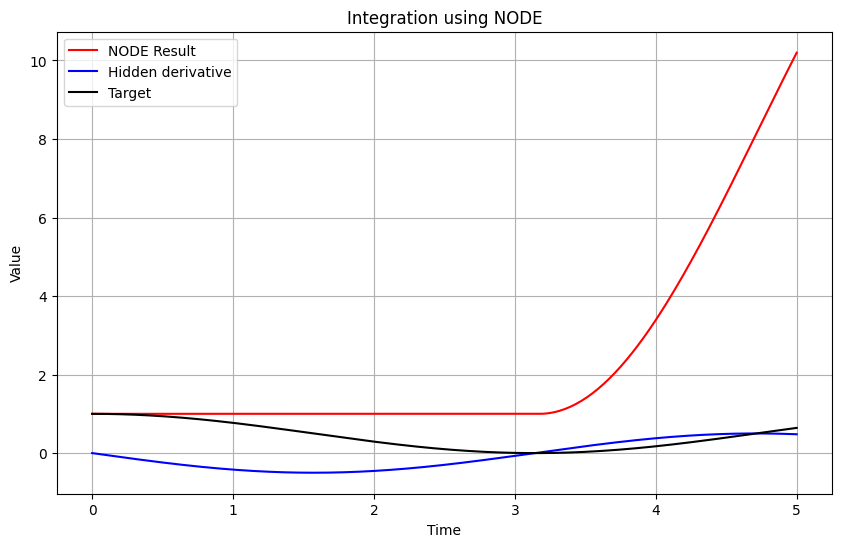

Epoch 0, Loss: 10.7137
Epoch 1, Loss: 9.5029
{'f_prime_model': {'layers_0': {'bias': Array([ -0.6168678, -45.04718  , 180.78104  ], dtype=float32), 'kernel': Array([[   0.37240276,   27.194952  , -109.13742   ]], dtype=float32)}, 'layers_1': {'bias': Array([358.23526], dtype=float32), 'kernel': Array([[225.52399 ],
       [ 86.61071 ],
       [ 52.410496]], dtype=float32)}}}


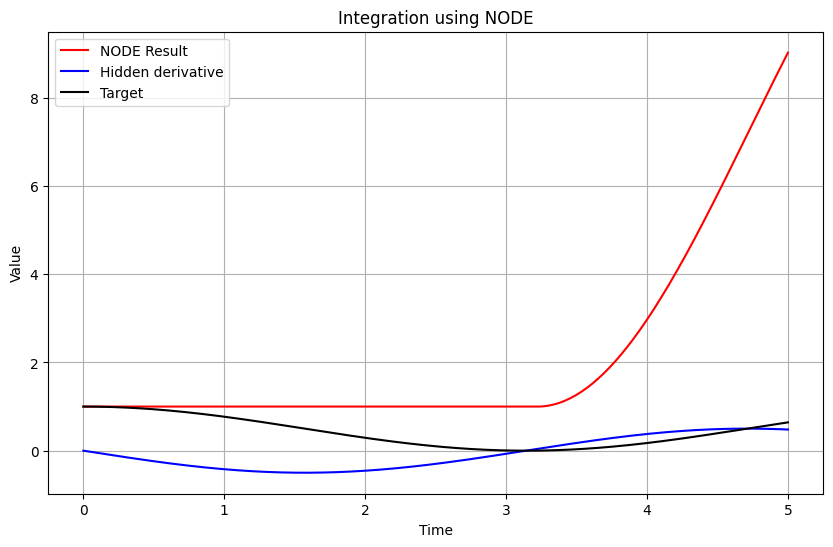

Epoch 2, Loss: 8.3800
Epoch 3, Loss: 7.3443
{'f_prime_model': {'layers_0': {'bias': Array([ -1.0970684, -37.822838 , 148.84358  ], dtype=float32), 'kernel': Array([[  0.6921293,  23.862043 , -93.903915 ]], dtype=float32)}, 'layers_1': {'bias': Array([296.10953], dtype=float32), 'kernel': Array([[195.56161 ],
       [ 75.745705],
       [ 44.34341 ]], dtype=float32)}}}


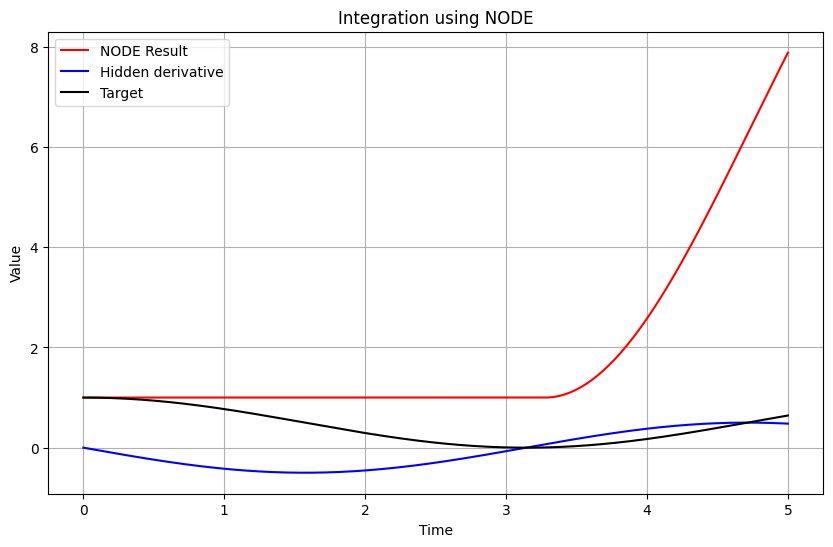

Epoch 4, Loss: 6.3966
Epoch 5, Loss: 5.5354
{'f_prime_model': {'layers_0': {'bias': Array([ -1.3602242, -31.173552 , 120.35698  ], dtype=float32), 'kernel': Array([[  0.8943052,  20.495647 , -79.131    ]], dtype=float32)}, 'layers_1': {'bias': Array([240.36804], dtype=float32), 'kernel': Array([[166.14001 ],
       [ 64.81407 ],
       [ 36.778885]], dtype=float32)}}}


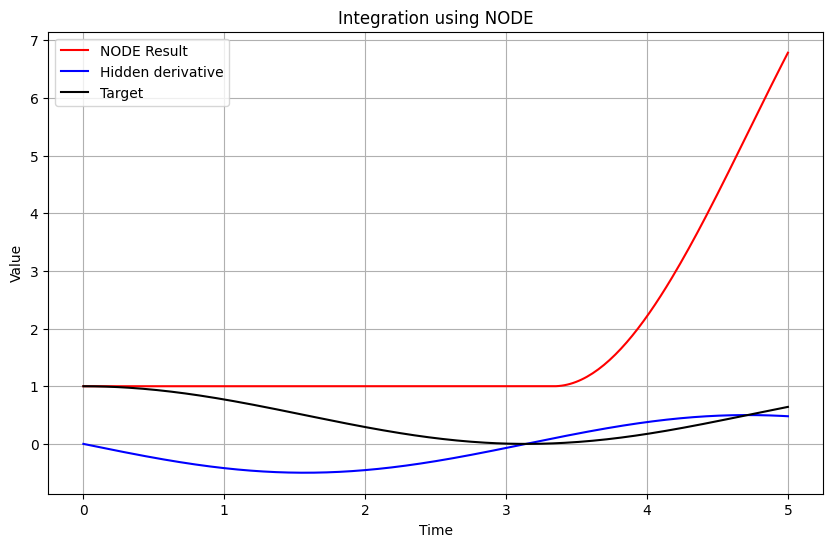

Epoch 6, Loss: 4.7583
Epoch 7, Loss: 4.0647
{'f_prime_model': {'layers_0': {'bias': Array([ -1.4470404, -25.167152 ,  95.39166  ], dtype=float32), 'kernel': Array([[  0.9887797,  17.197006 , -65.18224  ]], dtype=float32)}, 'layers_1': {'bias': Array([191.2309], dtype=float32), 'kernel': Array([[137.96814 ],
       [ 54.158466],
       [ 29.84818 ]], dtype=float32)}}}


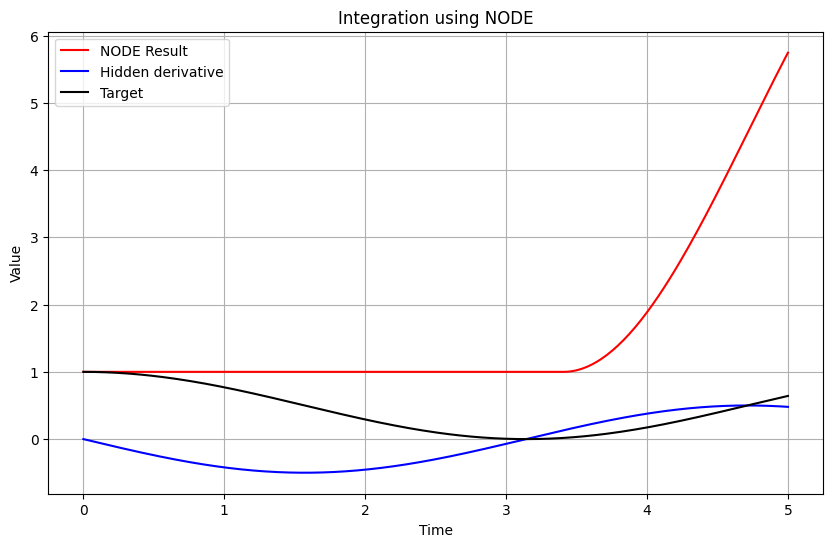

Epoch 8, Loss: 3.4504
Epoch 9, Loss: 2.9120
{'f_prime_model': {'layers_0': {'bias': Array([ -1.37201 , -19.459238,  72.468285], dtype=float32), 'kernel': Array([[  0.983456,  13.948372, -51.945225]], dtype=float32)}, 'layers_1': {'bias': Array([145.8069], dtype=float32), 'kernel': Array([[110.817085],
       [ 43.719837],
       [ 23.477028]], dtype=float32)}}}


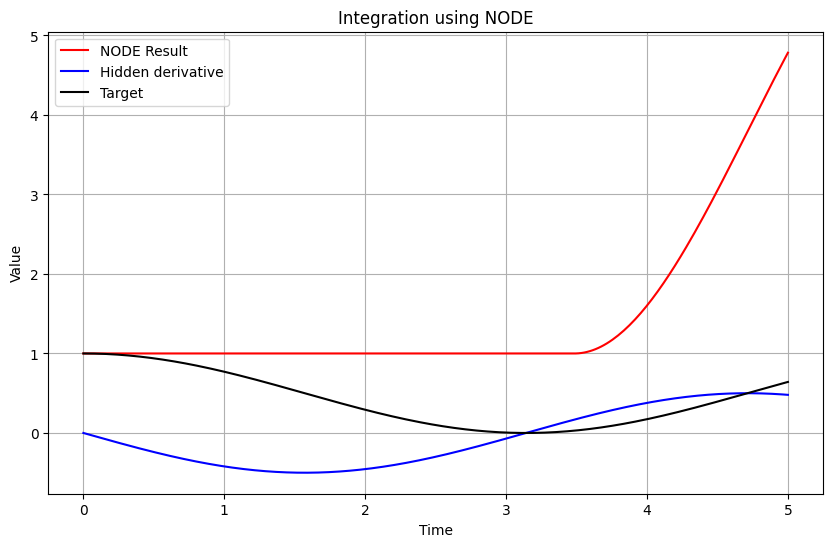

Epoch 10, Loss: 2.4457
Epoch 11, Loss: 2.0468
{'f_prime_model': {'layers_0': {'bias': Array([ -1.2084254, -14.63509  ,  53.603813 ], dtype=float32), 'kernel': Array([[  0.9048479,  10.958502 , -40.137592 ]], dtype=float32)}, 'layers_1': {'bias': Array([108.2254], dtype=float32), 'kernel': Array([[86.2778  ],
       [34.181248],
       [17.926933]], dtype=float32)}}}


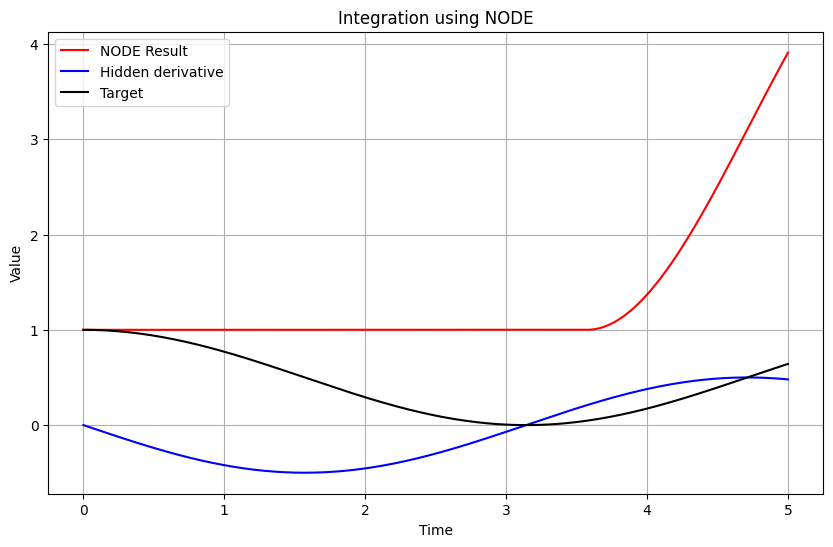

Epoch 12, Loss: 1.7099
Epoch 13, Loss: 1.4290
{'f_prime_model': {'layers_0': {'bias': Array([ -0.9997185, -10.679638 ,  38.515896 ], dtype=float32), 'kernel': Array([[  0.77882224,   8.319883  , -30.005486  ]], dtype=float32)}, 'layers_1': {'bias': Array([78.01524], dtype=float32), 'kernel': Array([[64.964134],
       [25.82515 ],
       [13.260596]], dtype=float32)}}}


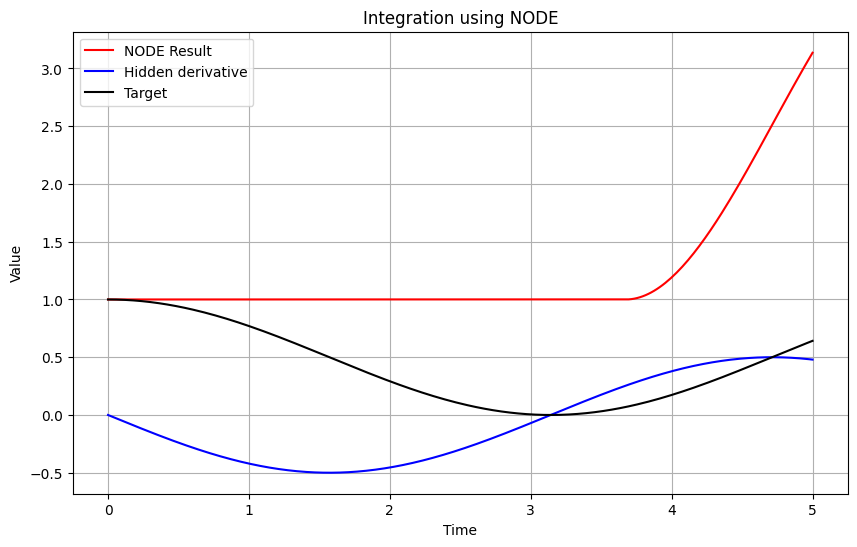

Epoch 14, Loss: 1.1982
Epoch 15, Loss: 1.0117
{'f_prime_model': {'layers_0': {'bias': Array([-0.74151474, -7.159695  , 25.458231  ], dtype=float32), 'kernel': Array([[  0.609723,   5.88718 , -20.933462]], dtype=float32)}, 'layers_1': {'bias': Array([51.720276], dtype=float32), 'kernel': Array([[45.61684 ],
       [18.174433],
       [ 9.179078]], dtype=float32)}}}


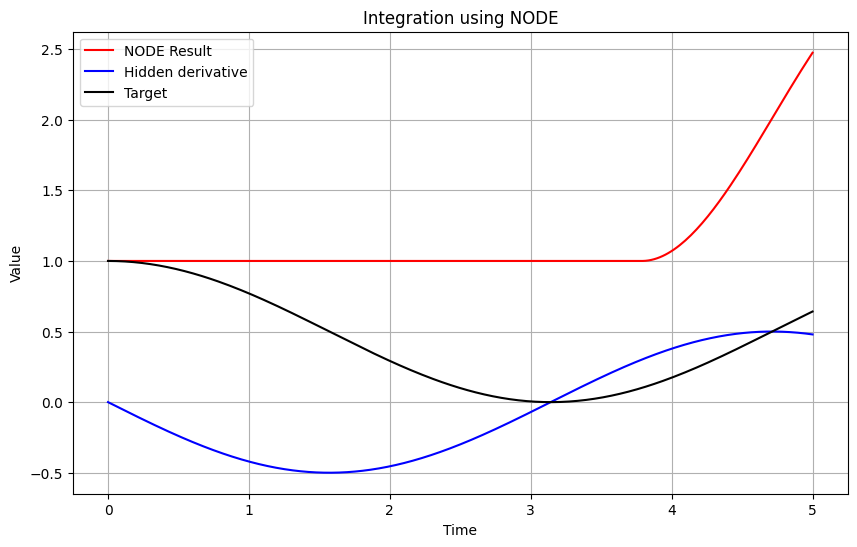

Epoch 16, Loss: 0.8636
Epoch 17, Loss: 0.7481
{'f_prime_model': {'layers_0': {'bias': Array([-0.51563466, -4.587424  , 16.105461  ], dtype=float32), 'kernel': Array([[  0.4441872,   3.9517806, -13.873852 ]], dtype=float32)}, 'layers_1': {'bias': Array([32.807507], dtype=float32), 'kernel': Array([[30.412714 ],
       [12.137575 ],
       [ 6.0426683]], dtype=float32)}}}


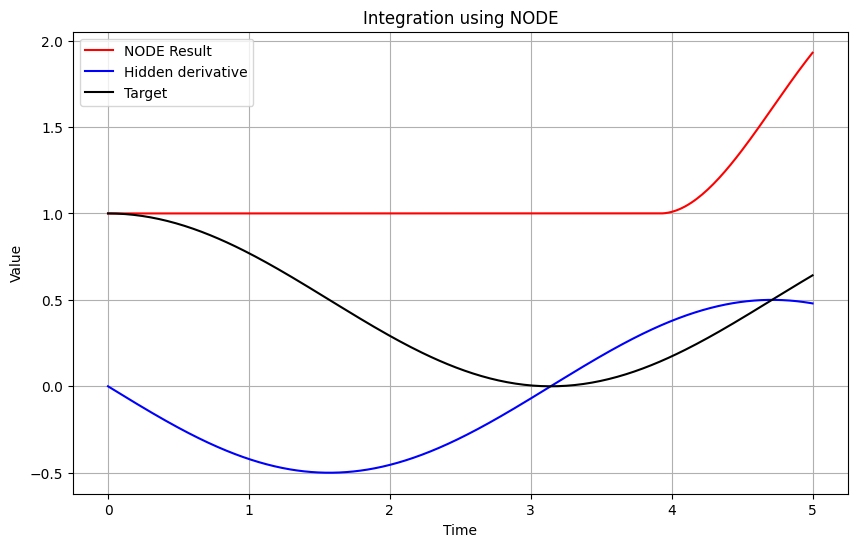

Epoch 18, Loss: 0.6600
Epoch 19, Loss: 0.5943
{'f_prime_model': {'layers_0': {'bias': Array([-0.32450897, -2.7017226 ,  9.379095  ], dtype=float32), 'kernel': Array([[ 0.2927395,  2.437224 , -8.460882 ]], dtype=float32)}, 'layers_1': {'bias': Array([19.15122], dtype=float32), 'kernel': Array([[18.644    ],
       [ 7.4490724],
       [ 3.666044 ]], dtype=float32)}}}


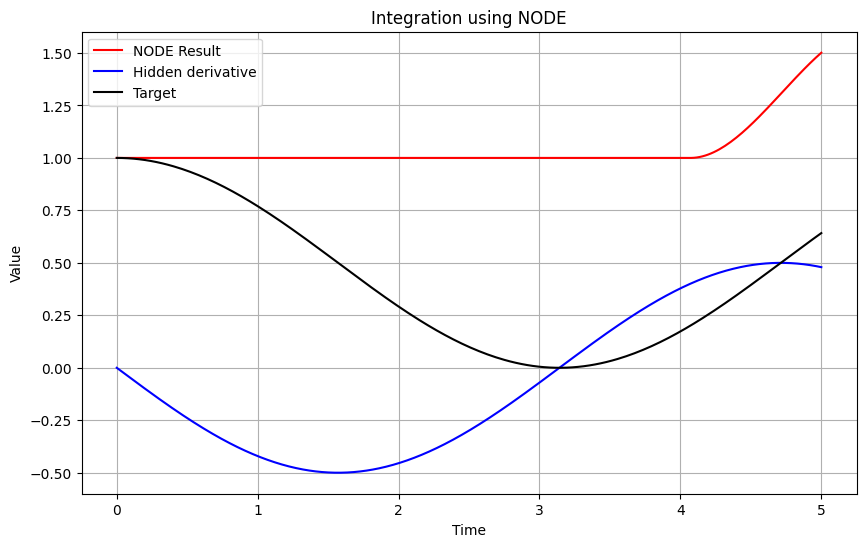

Epoch 20, Loss: 0.5465
Epoch 21, Loss: 0.5128
{'f_prime_model': {'layers_0': {'bias': Array([-0.18125013, -1.4301586 ,  4.916606  ], dtype=float32), 'kernel': Array([[ 0.17056431,  1.3458416 , -4.626741  ]], dtype=float32)}, 'layers_1': {'bias': Array([10.060118], dtype=float32), 'kernel': Array([[10.24147  ],
       [ 4.0949507],
       [ 1.9966426]], dtype=float32)}}}


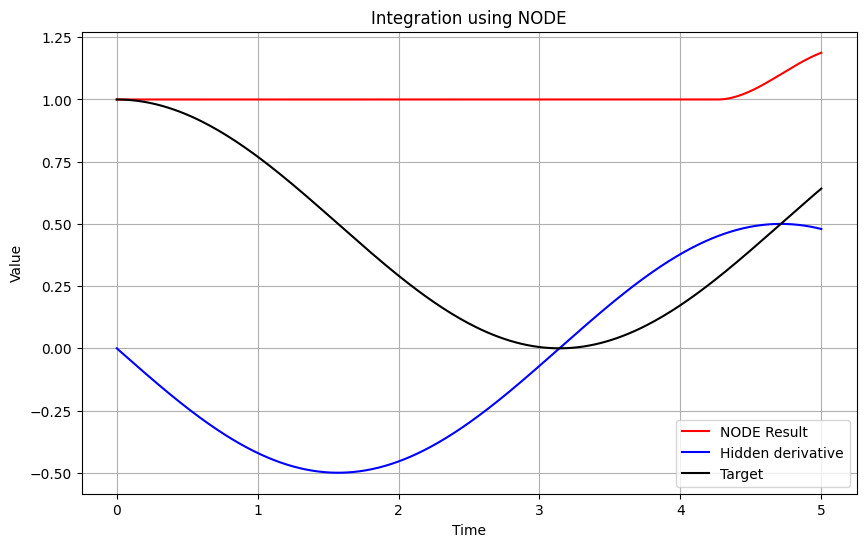

Epoch 22, Loss: 0.4899
Epoch 23, Loss: 0.4752
{'f_prime_model': {'layers_0': {'bias': Array([-0.07129588, -0.5387393 ,  1.8367082 ], dtype=float32), 'kernel': Array([[ 0.07000174,  0.5289601 , -1.8033688 ]], dtype=float32)}, 'layers_1': {'bias': Array([3.7648828], dtype=float32), 'kernel': Array([[4.006844 ],
       [1.6026951],
       [0.7761221]], dtype=float32)}}}


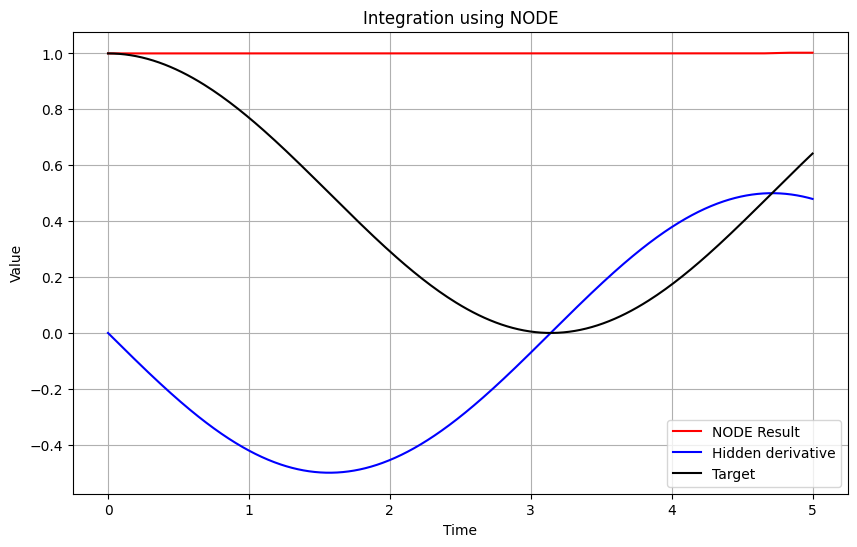

Epoch 24, Loss: 0.4666
Epoch 25, Loss: 0.4626
{'f_prime_model': {'layers_0': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[0., 0., 0.]], dtype=float32)}, 'layers_1': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
       [0.],
       [0.]], dtype=float32)}}}


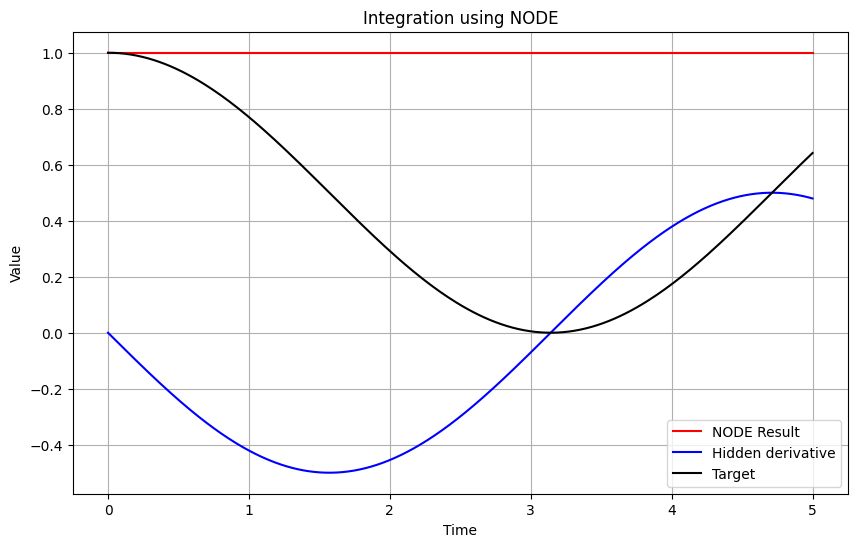

Epoch 26, Loss: 0.4625
Epoch 27, Loss: 0.4625
{'f_prime_model': {'layers_0': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[0., 0., 0.]], dtype=float32)}, 'layers_1': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
       [0.],
       [0.]], dtype=float32)}}}


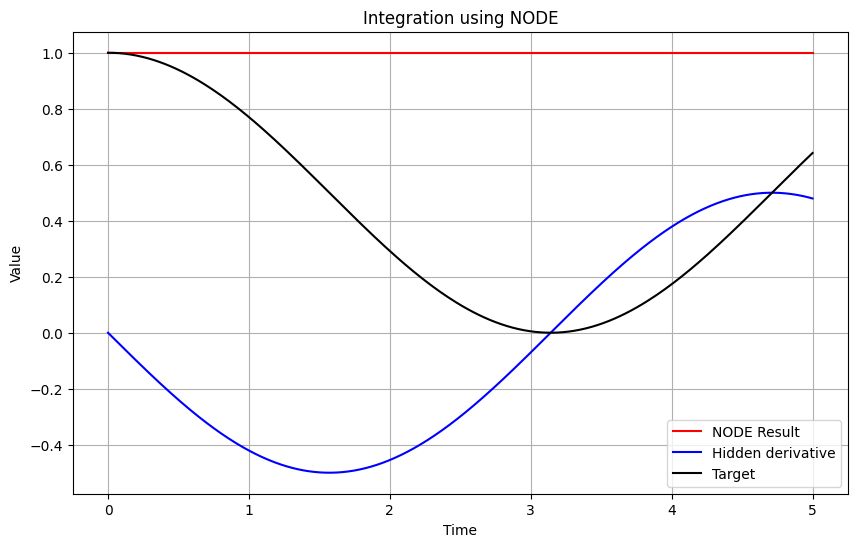

Epoch 28, Loss: 0.4625
Epoch 29, Loss: 0.4625


KeyboardInterrupt: 

In [111]:
from flax.training import train_state
import optax

# Real Data (Dataset)
t_values = jnp.linspace(0, 5, 1000)
u_values = u_function(t_values)
out_values = output(t_values, 1.0)

# Since our integrator might need to call the target parametrized function "derivative" multiple times points t, we first create an interpolator of u w.r.t. t
interp = Interpolator1D(t_values, u_values, method='linear')

# Initialize the model
deriv_model = approx_derivative()
model = NeuralODE(deriv_model, 'fixed-grid', 'euler', interp )
params = model.init(jax.random.PRNGKey(0), jnp.ones_like(t_evaluation), jnp.array(1.0))['params']
optimizer = optax.adam(learning_rate=1e-3)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer
)

# Inference Data
y0 = jnp.array(1.0)
t_evaluation = jnp.linspace(0, 5, 250)



epochs = 100
for epoch in range(epochs):

    def loss_fn(params):
        t_evals, pred_values = model.apply({'params': params}, t_evaluation, y0)
        return jnp.mean((pred_values - output(t_evaluation, y0)) ** 2)

    grad_fn = jax.value_and_grad(loss_fn)
    loss_val, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    if (epoch) % 2 == 0:
        print(grads)
        # Compute analytical solution
        analytical_results = output(t_evaluation, y0)

        fun_values = derivative(u_values)

        ts, node_result = model.apply({'params': state.params}, t_evaluation, y0)

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(t_evaluation, node_result, label='NODE Result', color='red')
        plt.plot(t_values, fun_values, label='Hidden derivative', color='blue', linestyle='-')
        #plt.plot(t_evaluated, result, label='Numerical Solution', color='red', linestyle='--')
        plt.plot(t_evaluation, analytical_results, label='Target', color='black')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Integration using NODE')
        plt.grid(True)
        plt.legend()
        plt.show()


    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {loss_val:.4f}')